In [47]:
from keras.models import Model
from keras.layers import Input, Reshape, Dot, Flatten, Lambda
from keras.layers import Concatenate, Dense, Dropout, Activation
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.regularizers import l2

%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd

from lenskit import batch, util
from lenskit import crossfold as xf
from lenskit.algorithms import funksvd
from lenskit.metrics.predict import rmse

import numpy as np

In [48]:
ratings = pd.read_csv('ml-1m/ratings.dat', sep='::', engine='python',
                      names=['user', 'item', 'rating', 'timestamp'])

In [49]:
splits = []

for train, test in xf.partition_users(ratings[['user', 'item', 'rating']], 5, xf.SampleFrac(0.2)):
    splits.append((train, test))

In [50]:
def evaluate( aname, algo, train, test):
    fittable = util.clone(algo)
    # Train the algo
    fittable.fit(train)
    # Generate predictions
    recs = batch.predict(fittable, test)
    recs['Algorithm'] = aname
    return recs

In [51]:
all_recs = []
test_data = []
for train, test in splits:
    f_svd = funksvd.FunkSVD(20)
    test_data.append(test)
    all_recs.append(evaluate('funk_svd_20', f_svd, train, test))

all_recs_df = pd.concat(all_recs, ignore_index=True)
algo_rmse = all_recs_df.groupby('Algorithm').apply(lambda df: rmse(df.prediction, df.rating)).rename('RMSE values')

In [52]:
algo_rmse

Algorithm
funk_svd_20    0.856871
Name: RMSE values, dtype: float64

In [59]:
from keras import backend as K

# Source: https://stackoverflow.com/a/43863854/4031302
# Keras only provided the option of MSE and not RMSE.
# This function defines custom RMSE function, which is used for loss calculation in our NN.
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

n_users = ratings.user.max()+1
n_movies = ratings.item.max()+1
n_factors = 50

c:\users\magic\envs\datascience\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Mean RMSE for Recommender v1: 0.7423263025408607


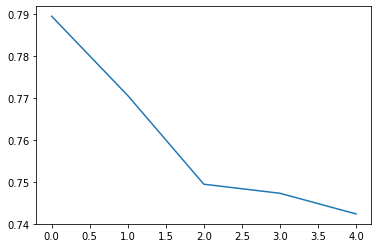

In [57]:
# Sources:
# https://medium.com/@jdwittenauer/deep-learning-with-keras-recommender-systems-e7b99cb29929
# Here we try to replicate matrix factorization, by learning the user and movie embeddings
# in a 50 dimensional space
def RecommenderV1(n_users, n_movies, n_factors):
    user = Input(shape=(1,))
    # Embedding layer learns a 50-dimensional representation for users.
    u = Embedding(n_users, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(user)
    u = Flatten()(u)
    
    movie = Input(shape=(1,))
    # Similar to previous embedding layer, this learns movie representations
    m = Embedding(n_movies, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(movie)
    m = Flatten()(m)
    
    # Just like in the case of matrix factorization, we take product of user and movie embeddings.
    # This is trained to be equal to actual rating.
    x = Dot(axes=1)([u, m])
    model = Model(inputs=[user, movie], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss=root_mean_squared_error, optimizer=opt)
    return model

nn_rmse = []
for train, test in splits:
    model = RecommenderV1(n_users, n_movies, n_factors)
    X_train = [train['user'].values, train['item'].values]
    Y_train = train['rating'].values
    
    X_test = [test['user'].values, test['item'].values]
    Y_test = test['rating'].values
    
    history = model.fit(x=X_train, y=Y_train, batch_size=64, epochs=5,
                    verbose=0, validation_data=(X_test, Y_test))
    nn_rmse.append(history.history['val_loss'][-1])
    break # Remove this to run 5-fold cross validation. Takes >40 min.

plt.plot(history.history['val_loss'])
print("Mean RMSE for Recommender v1:", np.mean(nn_rmse))

c:\users\magic\envs\datascience\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 958560 samples, validate on 41649 samples
Epoch 1/5
958560/958560 [==============================] - 149s 156us/step - loss: 0.7725 - val_loss: 0.7210
Epoch 2/5
958560/958560 [==============================] - 152s 158us/step - loss: 0.7491 - val_loss: 0.7178
Epoch 3/5
958560/958560 [==============================] - 154s 161us/step - loss: 0.7461 - val_loss: 0.7158
Epoch 4/5
958560/958560 [==============================] - 151s 157us/step - loss: 0.7442 - val_loss: 0.7165
Epoch 5/5
958560/958560 [==============================] - 150s 157us/step - loss: 0.7434 - val_loss: 0.7139
Mean RMSE for Recommender v1: 0.7138751319952894


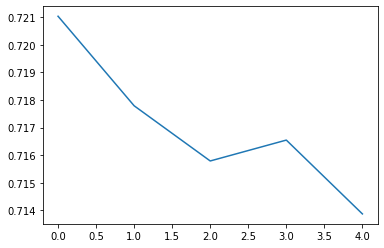

In [58]:
# Sources:
# https://medium.com/@iliazaitsev/how-to-implement-a-recommendation-system-with-deep-learning-and-pytorch-2d40476590f9
# https://medium.com/@jdwittenauer/deep-learning-with-keras-recommender-systems-e7b99cb29929
def RecommenderV2(n_users, n_movies, n_factors):
    # Here we try to learn more complex representations by introducing dense layers
    # on top of the embeddings we learned.
    user = Input(shape=(1,))
    u = Embedding(n_users, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(user)
    u = Flatten()(u)
    
    movie = Input(shape=(1,))
    m = Embedding(n_movies, n_factors, embeddings_initializer='he_normal',
                  embeddings_regularizer=l2(1e-6))(movie)
    m = Flatten()(m)
    
    # Concatenate the embeddings and feed them together as input to the dense layers.
    # The picture of architecture is shown in source 1.
    x = Concatenate()([u, m])
    
    # Dropout layer randomly sets learning of some inputs to 0.
    # Prevents over-fitting, which is a valid concern since we're learning huge number of parameters.
    x = Dropout(0.05)(x)
    
    x = Dense(10, kernel_initializer='he_normal')(x)
    # Relu activation introduces some non-linearity to the model.
    # Helps learn non-linear relations in the data.
    x = Activation('relu')(x)
    
    x = Dropout(0.5)(x)
    
    # Another dense layer to learn better, more complex relations.
    x = Dense(1, kernel_initializer='he_normal')(x)
    
    # We use sigmoid function to scale the output to our required scale.
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)
    
    model = Model(inputs=[user, movie], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss=root_mean_squared_error, optimizer=opt)
    return model

max_rating=5.0; min_rating=0.0

improved_rmse = []
for train, test in splits:
    model = RecommenderV2(n_users, n_movies, n_factors)
    X_train = [train['user'].values, train['item'].values]
    Y_train = train['rating'].values
    
    X_test = [test['user'].values, test['item'].values]
    Y_test = test['rating'].values
    
    history = model.fit(x=X_train, y=Y_train, batch_size=64, epochs=5,
                    verbose=1, validation_data=(X_test, Y_test))
    improved_rmse.append(history.history['val_loss'][-1])
    break # Remove this to run cross validation. Takes >40 min.

plt.plot(history.history['val_loss'])
print("Mean RMSE for Recommender v1:", np.mean(improved_rmse)) # Should be v2

## Results comparision

(RMSE values)

- Funk SVD : 0.856871
- Recommender v1: 0.742
- Recommender v2: 0.713

## Sources:
For the funk SVD part, we re-used code from previous assignments.

We consulted following blogs to explore design of neural networks:
- For the imroved algorithm idea: https://medium.com/@iliazaitsev/how-to-implement-a-recommendation-system-with-deep-learning-and-pytorch-2d40476590f9
- For the basic implementation code: https://medium.com/@jdwittenauer/deep-learning-with-keras-recommender-systems-e7b99cb29929
- For Root mean square implementation in tensorflow: https://stackoverflow.com/a/43863854/4031302